In [1]:
import fsps
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt

In [4]:
#This is to make graphs more interactive. Turn this off if it does not work.
from matplotlib import cm

# Get GOGREEN data

The following is modified code taken from
https://github.com/noaodatalab/notebooks-latest/blob/master/03_ScienceExamples/GOGREEN_GalaxiesInRichEnvironments/GOGREENDr1DataAccessAtDataLab.ipynb

Please refer to this source for more information on retreiving data from the GOGREEN suvey
Credit for the code in this section goes to the original authors, Michael Balogh and Robert Nikutta

In [ ]:
author = 'Michael Balogh <mbalogh@uwaterloo.ca>, Robert Nikutta <robert.nikutta@noirlab.edu>'
version = '20211122' # yyymmdd
datasets = ['gogreen_dr1']
keywords = ['gemini llp','tap','cluster','photometry','redshift','file service','spectra','catalogues']


In [ ]:
# std lib
from io import BytesIO
import gzip

# 3rd party
import numpy as np
np.warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_columns', 500) # convenient for 

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

from astropy.io import fits, ascii
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3) # define cosmology

# Data Lab
from dl import queryClient as qc, storeClient as sc

In [ ]:
oneddir = 'gogreen_dr1://SPECTROSCOPY/OneD/'  # 1-d spectra
twoddir = 'gogreen_dr1://SPECTROSCOPY/TwoD/'  # 2-d spectra
imdir = 'gogreen_dr1://PHOTOMETRY/IMAGES/'    # photometry and images

In [ ]:
cluster_table = qc.query('select * from gogreen_dr1.clusters',fmt='pandas')
print("Column names:", cluster_table.columns)
cluster_table.head(10)  # first 10 rows of the table

In [ ]:
phot_table = qc.query('select * from gogreen_dr1.photo',fmt='pandas')
print("Column names:", phot_table.columns)
phot_table.head(10)  # first 10 rows of the table

In [ ]:
redshift_table = qc.query('select * from gogreen_dr1.redshift',fmt='pandas')
print("Column names:", redshift_table.columns)
redshift_table.head(10)  # first 10 rows of the table

In [ ]:
# this way avoids duplicate columns (ie dont need to specify suffixes)
merge_col = ['specid']
cols_to_use = phot_table.columns.difference(redshift_table.columns).tolist() + merge_col
matched_table = pd.merge(redshift_table, phot_table[cols_to_use], how='left', \
                         left_on=['specid'], right_on=merge_col )
merge_col = ['cluster']

# Here attach suffix _c to distinguish between galaxy values (Redshift) and cluster values (Redshift_c)
matched_table = pd.merge(matched_table, cluster_table, how='left', \
                         left_on=['cluster'], right_on=merge_col, suffixes=['','_c'] )
print("Column names:", matched_table.columns.values)
matched_table.head(20)  # show the first 20 rows of the matched table

In [ ]:
bin_range = ([0,1.8],[0.2,2.2])
cmap = 'gray_r'

# use full photometric catalogue
selection = '(zphot>0.8) & (zphot<1.5) & (mstellar>10**10) & (mstellar<10**10.5)'
UminV,VminJ,photz,mass = phot_table.query(selection)[['uminv','vminj','zphot','mstellar']].values.T
lmass = np.log10(mass)

selection = '(redshift_quality>2) & (redshift>=0.8) & (redshift<=1.5) & (mstellar>10**10) & (mstellar<10**10.5)'
#selection = '(redshift_quality>2) & (redshift>=0.8) & (redshift<=1.5)'
UminVspec,VminJspec,mem = matched_table.query(selection)[['uminv','vminj','member']].values.T

# Show in greyscale all galaxies with stellar mass between 9.5 and 12, and photo-z between 0.8 and 1.5
Nbins = 20
N,xedges,yedges = np.histogram2d( VminJ, UminV, bins=Nbins, range=bin_range)
N = N.T
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
X, Y = np.meshgrid(xedges, yedges)

fig,ax=plt.subplots(1,1,figsize=(13,13))

field = ax.imshow(N, interpolation='nearest', origin='lower',cmap=cmap,vmin=0,vmax=800,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

ax.scatter(VminJspec, UminVspec, c='yellow', edgecolor='k', alpha=1, s=25, label='Spectroscopic non-members')

ax.scatter(VminJspec[mem==1], UminVspec[mem==1], c='red', edgecolor='k', alpha=1, s=25, label='Cluster members')

ax.legend()
ax.set_ylim(0.2,2.2)
ax.set_xlim(0,1.8)
ax.set_xlabel("(V-J)")
ax.set_ylabel("(U-V)")
fig.show()

In [ ]:
plt.scatter(VminJspec, UminVspec,alpha=1,s=2)
#plt.scatter(VminJspec[mem==1], UminVspec[mem==1],alpha=1,s=2)
with open('VminJspec1.txt','w') as f:
    f.write('[')
    for ii in range(0,len(VminJspec)):
        f.write(str(VminJspec[ii])+",")
    f.write(']')
with open('UminVspec1.txt','w') as f:
    f.write('[')
    for ii in range(0,len(UminVspec)):
        f.write(str(UminVspec[ii])+',')
    f.write(']')

# Generate FSPS Data

#This is a function developed by Prof. M. Balogh to determine the lien widths of H_delta or OIII lines. We will make use of this later

In [3]:

def line_index(wave,flux,reg):
    dwave=wave[1:]-wave[0:-1]
    dwave=np.append(dwave,dwave[len(dwave)-1])
# Do this for equivalent width measurements
#    if np.size(reg)==6:
    def_cont=np.where( ( (wave>=reg[0]) & (wave<=reg[1]) ) | (wave>=reg[4]) & (wave<=reg[5]))
    def_feature=np.where((wave>=reg[2]) & (wave<=reg[3]))
    #dwave=reg[3]-reg[2]
    contfit=np.polyfit(wave[def_cont],flux[def_cont],1)#,w=1./unc[def_cont])
    cont=contfit[0]*wave+contfit[1]
    y=np.sum((flux[def_feature]/cont[def_feature]-1)*dwave[def_feature])
    return -y

#The following is the main running differnt paths. It will iterate over many slopes, truncation times, and dust values. Expect this to take about a day and a half to run. It will write all of the outputs to textfiles. A previous run of these should be included with the code, so it may not be necessary to run this.

In [54]:
reg = [4030,4082,4082,4122,4122,4170] #For use with the linewidth code

#Initialize constants, even if some may be changed later (we need initial parameters)
start = .1
trunk = .1
zred = 0.0 #No redshift
tau = 100.0 #Large Tau to simulate constant star forming
metal = 0.0 #Solar metlalisity
dust = 2.0
sfh = 5

#===============Change this to 0.4 for the other result.
mindust = 0

dust1 = dust
bands_in = [ 'galex_nuv', 'sdss_u', 'fors_v', 'vista_j' ] #Colour bands that we will be using

#create initial stellar population model
sp = fsps.StellarPopulation(compute_vega_mags=False, zcontinuous=1, tau = tau,
                            sfh=sfh, logzsol=metal, dust_type=2, dust2=dust,sf_trunc=trunk,sf_slope=-1)
                            
start_time = dt.now() #time how long it takes the code to run
print("Started")

#initialize output arrays for times
times_out = []
times_bq = []
times_gv = []

trunk_v = []
trunk_u = []
trunk_n = []
dust_a =[]
trunk_a = []

trunk_d4 = []
trunk_hd = []

for nn in range(1,7):
    slope = nn #Iterate over slopes
    for kk in range(0,30): #Iterate over dust values
        dust1 = kk*0.1 #Dust goes from 0.1 - 3
        for jj in range(0,50): #Iterate over truncation times
            dust_a.insert(kk*75+jj,dust1)
            dust = dust1
            
            trunk = 7-1.789*np.log(50-jj)#Truncation times varied on log scale to space out colour-colour values
            trunk_a.insert(jj,trunk)
            sp.params['sf_slope'] = -slope
            sp.params['sf_trunc'] = trunk
            
            #get star formation rate at truncation
            sp.params['tage'] = trunk
            sfr_0 = sp.sfr
            sp.params['tage'] = 0
            
            #initialize colour band arrays
            nuv_v=[]
            v_j=[]
            u_v=[]
            nuv_v1=[]
            v_j1=[]
            u_v1=[]
            blue = []
            red = []
            ha = []
        
            time_out = 0
            time_bq = 0
            time_gv = 0
            trunk_start = 0
            
            #Iterate from start time to start time + 13 Gyr
            for ii in range(0,int(1300)): 
                time = start+ii*0.01
                #Have dust decrease linearly after truncation
                if time > trunk and trunk!= 0:
                    dust = max(mindust, dust1-slope*(time-trunk))
                sp.params['dust2'] = dust
                #Get the D4000 and H_delta width
                wave,spec = sp.get_spectrum(tage=time)
                ha.insert(ii,line_index(wave,spec,reg))
                wave_start = np.argmin(abs(3850-wave))
                wave_end = np.argmin(abs(3950-wave))
                spec_sec = sum(spec[wave_start:wave_end]/(wave[wave_start:wave_end]*wave[wave_start:wave_end]))
                blue.insert(ii,spec_sec)
                wave_start = np.argmin(abs(4000-wave))
                wave_end = np.argmin(abs(4100-wave))
                spec_sec = sum(spec[wave_start:wave_end]/(wave[wave_start:wave_end]*wave[wave_start:wave_end]))
                red.insert(ii,spec_sec)
                
                #record time in Post starburst region
                if red[ii]/blue[ii]  < 1.45 and time > trunk and sp.sfr < sfr_0/10:
                    time_out = round(time - trunk,2)
                
                #Get colour values
                mags = sp.get_mags(tage=time,bands = bands_in)
                nuv_v1.insert(ii, mags[0] - mags[2])
                v_j1.insert(ii,mags[2] - mags[3] )
                u_v1.insert(ii,mags[1] - mags [2] )
                
                #record location on plots at time of truncation
                if time >= trunk and trunk_start == 0:
                    trunk_v.insert(jj+kk*50,v_j1[ii])
                    trunk_u.insert(jj+kk*50,u_v1[ii])
                    trunk_n.insert(jj+kk*50,nuv_v1[ii])
                    trunk_d4.insert(jj+kk*50,red[ii]/blue[ii])
                    trunk_hd.insert(jj+kk*50,ha[ii])
                    trunk_start = 1
            
                b_1 = v_j1[ii] + 0.45
                b_2 = -1.25*v_j1[ii] + 2.025
                t_1 = -1.25*v_j1[ii] + 2.7
                t_2 = v_j1[ii] + 1.35
                
                b_g = 2*v_j1[ii] + 1.1
                t_g = 2*v_j1[ii] + 1.6
                
                #record time in BQ region and GV region
                if mags[1] - mags[2] > b_1 and mags[1] - mags[2] > b_2 and mags[1] - mags[2] < t_1 and mags[1] - mags[2] < t_2:
                    time_bq += round(0.01,3)
                if b_g <= nuv_v1[ii] and nuv_v1[ii] <= t_g:
                    time_gv += round(0.01,3)
            times_out.insert(jj+kk*50,time_out)
            times_bq.insert(jj+kk*50,round(time_bq,3))
            times_gv.insert(jj+kk*50,round(time_gv,3))
            print(dt.now()-start_time)
    #Record data to text files
    out_data=[times_out,times_bq,times_gv,trunk_v,trunk_u,trunk_n,
          dust_a,trunk_a,trunk_d4,trunk_hd]
    out_names=['times_out_{}','times_bq_{}','times_gv_{}',
                        'trunk_v_{}','trunk_u_{}','trunk_n_{}',
                        'dust_a_{}','trunk_a_{}','trunk_d4_{}','trunk_hd_{}']
    for ii in range(0,len(out_data)):
        if mindust == 0:
            with open('437_text/{}_t3.txt'.format(out_names[ii].format(slope)),'w') as f:
                f.write(str(out_data[ii]))
        else:
            with open('437_text/{}_dp4.txt'.format(out_names[ii].format(slope)),'w') as f:
                f.write(str(out_data[ii]))
                

Started
0:01:35.694085
0:01:49.814358
0:02:03.015561
0:02:15.472576
0:02:29.422262
0:02:41.397884
0:02:54.319978
0:03:08.570566
0:03:22.886411
0:03:37.367326
0:03:51.556258
0:04:05.447835
0:04:19.783755
0:04:36.323303
0:04:51.337602
0:05:04.689188
0:05:18.766077
0:05:32.502004
0:05:44.611083
0:05:56.864854
0:06:09.008243
0:06:22.074668
0:06:37.213577
0:06:55.213641
0:07:10.763418
0:07:26.534914
0:07:39.340470
0:07:51.905923
0:08:04.608538
0:08:22.899121
0:08:38.346654
0:08:51.370296
0:09:03.934133
0:09:16.432566
0:09:29.469089
0:09:44.973595
0:10:01.895754
0:10:21.166420
0:10:36.349167
0:10:53.115704
0:11:08.922356
0:11:23.708907
0:11:40.139475
0:11:57.994182
0:12:17.388867
0:12:35.873527
0:12:50.518449
0:13:07.149372
0:13:22.812971
0:13:42.338487
0:13:56.518907
0:14:09.989295
0:14:23.355159
0:14:36.302495
0:14:48.047365
0:15:00.158112
0:15:14.377097
0:15:28.549829
0:15:48.180088
0:16:04.430297
0:16:20.028849
0:16:35.824654
0:16:52.128332
0:17:08.383897
0:17:22.027979
0:17:39.984222
0:

2:08:41.205541
2:08:55.310283
2:09:10.695203
2:09:28.257685
2:09:42.354415
2:09:56.381515
2:10:10.485726
2:10:24.508819
2:10:38.562915
2:10:52.624571
2:11:06.749562
2:11:21.000290
2:11:35.334215
2:11:49.429100
2:12:03.488941
2:12:17.735599
2:12:31.826833
2:12:46.058492
2:13:00.357117
2:13:13.298236
2:13:25.367158
2:13:37.412039
2:13:49.475902
2:14:01.564351
2:14:13.891072
2:14:26.164150
2:14:38.416592
2:14:50.724632
2:15:03.033686
2:15:15.636570
2:15:28.033771
2:15:40.451416
2:15:52.923065
2:16:05.414464
2:16:18.151937
2:16:30.721908
2:16:43.310160
2:16:56.009767
2:17:08.988617
2:17:21.786087
2:17:34.617763
2:17:47.537931
2:18:00.517688
2:18:15.319197
2:18:30.848014
2:18:46.480516
2:19:02.211995
2:19:18.271338
2:19:34.354443
2:19:50.521456
2:20:06.841991
2:20:20.946401
2:20:35.383696
2:20:50.425555
2:21:02.196263
2:21:14.480658
2:21:26.269295
2:21:38.055114
2:21:49.858722
2:22:01.647032
2:22:13.629525
2:22:25.508984
2:22:37.395083
2:22:49.296233
2:23:01.206353
2:23:13.215270
2:23:25.16

4:12:40.305378
4:12:53.915254
4:13:07.780253
4:13:21.741502
4:13:35.966774
4:13:50.526861
4:14:05.724239
4:14:17.666440
4:14:29.556246
4:14:41.427219
4:14:53.327585
4:15:08.112842
4:15:25.923909
4:15:37.815773
4:15:49.729831
4:16:01.663447
4:16:13.921319
4:16:26.001664
4:16:38.009248
4:16:50.044848
4:17:02.097197
4:17:14.374161
4:17:26.496335
4:17:38.603466
4:17:50.732830
4:18:02.903121
4:18:15.352913
4:18:27.583845
4:18:39.836977
4:18:52.102888
4:19:04.399095
4:19:19.008335
4:19:33.713406
4:19:48.417590
4:20:03.155422
4:20:17.997820
4:20:32.795640
4:20:47.655617
4:21:02.608658
4:21:16.116973
4:21:28.743429
4:21:41.541228
4:21:54.409680
4:22:07.457223
4:22:20.397627
4:22:33.429038
4:22:46.560041
4:22:59.678861
4:23:13.142222
4:23:26.477306
4:23:39.971469
4:23:53.601804
4:24:07.562643
4:24:23.694291
4:24:40.466055
4:24:57.596776
4:25:13.939858
4:25:25.784097
4:25:37.645247
4:25:49.484790
4:26:01.337727
4:26:13.486544
4:26:25.395408
4:26:37.327324
4:26:49.317624
4:27:01.289078
4:27:13.43

6:11:04.922176
6:11:20.456105
6:11:36.037458
6:11:50.915634
6:12:04.330166
6:12:18.053348
6:12:31.714176
6:12:45.708077
6:13:00.021892
6:13:14.960810
6:13:26.487072
6:13:38.084721
6:13:49.759198
6:14:01.422199
6:14:13.223607
6:14:24.862596
6:14:36.492400
6:14:48.211724
6:14:59.946740
6:15:13.047495
6:15:25.056368
6:15:36.802897
6:15:49.008326
6:16:03.018845
6:16:16.521205
6:16:30.769182
6:16:45.185712
6:16:59.645232
6:17:12.737834
6:17:24.714486
6:17:36.694442
6:17:48.816637
6:18:00.973310
6:18:14.832897
6:18:29.444345
6:18:44.122897
6:18:58.889242
6:19:13.663949
6:19:28.338562
6:19:43.106934
6:19:57.971691
6:20:11.743876
6:20:24.183971
6:20:36.721990
6:20:49.421235
6:21:02.148436
6:21:15.024110
6:21:27.717975
6:21:40.582461
6:21:53.596144
6:22:06.891469
6:22:19.929101
6:22:33.088882
6:22:46.540682
6:23:00.041059
6:23:13.827507
6:23:27.551465
6:23:41.792199
6:23:56.169531
6:24:11.237164
6:24:22.813267
6:24:34.415492
6:24:46.082614
6:24:57.803900
6:25:10.386214
6:25:24.189504
6:25:38.01

8:09:40.358486
8:09:55.753140
8:10:11.326101
8:10:26.908918
8:10:42.557928
8:10:58.310834
8:11:14.431980
8:11:30.484978
8:11:46.730291
8:12:03.115972
8:12:17.711653
8:12:32.152280
8:12:47.203463
8:12:58.935578
8:13:10.862445
8:13:22.607588
8:13:34.389135
8:13:46.178439
8:13:57.984325
8:14:10.785070
8:14:24.918141
8:14:39.106744
8:14:53.354016
8:15:07.436006
8:15:19.345036
8:15:31.270974
8:15:43.222128
8:15:55.204142
8:16:07.378301
8:16:19.851759
8:16:31.895192
8:16:43.983147
8:16:56.093425
8:17:08.399017
8:17:20.558273
8:17:32.742706
8:17:44.941079
8:17:57.173027
8:18:10.189039
8:18:24.790251
8:18:39.461505
8:18:54.156421
8:19:09.144416
8:19:23.817367
8:19:38.606108
8:19:53.348246
8:20:07.920022
8:20:20.555188
8:20:33.248197
8:20:46.035337
8:20:58.879806
8:21:13.206508
8:21:28.350472
8:21:43.994887
8:21:59.720002
8:22:15.652006
8:22:30.972399
8:22:44.528505
8:22:58.254183
8:23:13.584684
8:23:30.277968
8:23:47.274880
8:24:04.942291
8:24:19.158450
8:24:33.253688
8:24:47.437395
8:25:01.55

10:10:04.524185
10:10:19.450843
10:10:34.529366
10:10:49.635721
10:11:04.744147
10:11:20.080239
10:11:35.255659
10:11:50.584335
10:12:06.140192
10:12:21.513306
10:12:36.967536
10:12:52.528473
10:13:08.270718
10:13:23.998694
10:13:39.864456
10:13:56.112309
10:14:12.681857
10:14:29.204385
10:14:46.055243
10:15:03.493514
10:15:15.733863
10:15:27.465674
10:15:39.184850
10:15:50.921561
10:16:02.677929
10:16:15.036955
10:16:26.733655
10:16:38.550855
10:16:50.397274
10:17:02.247148
10:17:14.328316
10:17:26.253841
10:17:38.221347
10:17:50.204999
10:18:02.219932
10:18:14.449895
10:18:26.523463
10:18:38.610027
10:18:50.723692
10:19:02.864842
10:19:15.177772
10:19:27.395632
10:19:39.636343
10:19:51.901247
10:20:04.211364
10:20:16.675702
10:20:29.034002
10:20:41.434635
10:20:53.879619
10:21:06.564664
10:21:19.001119
10:21:31.463710
10:21:44.064252
10:21:58.706330
10:22:12.616487
10:22:25.365283
10:22:38.151461
10:22:51.043114
10:23:03.971838
10:23:17.126600
10:23:30.170622
10:23:43.363176
10:23:56

12:02:01.304257
12:02:14.898345
12:02:28.658075
12:02:42.455920
12:02:56.533968
12:03:11.042190
12:03:25.986339
12:03:39.776735
12:03:53.772802
12:04:07.777649
12:04:21.791646
12:04:35.831282
12:04:49.923565
12:05:04.038144
12:05:18.299669
12:05:31.805835
12:05:43.741921
12:05:55.688773
12:06:07.662564
12:06:19.907678
12:06:31.875184
12:06:43.863733
12:06:55.941069
12:07:08.173026
12:07:20.315438
12:07:32.649081
12:07:44.821119
12:07:56.934456
12:08:09.184738
12:08:21.445212
12:08:33.824280
12:08:46.049086
12:08:58.314819
12:09:10.782710
12:09:23.099581
12:09:38.807487
12:09:51.379844
12:10:03.996646
12:10:16.603770
12:10:29.218256
12:10:41.831927
12:10:54.542645
12:11:07.518144
12:11:20.254603
12:11:33.284811
12:11:46.202241
12:11:59.191054
12:12:12.282045
12:12:25.450517
12:12:38.696728
12:12:52.056454
12:13:05.669498
12:13:19.294576
12:13:34.269669
12:13:50.916199
12:14:07.914491
12:14:25.466918
12:14:39.475305
12:14:53.494593
12:15:07.397087
12:15:19.106094
12:15:31.571005
12:15:45

13:54:51.204319
13:55:03.003135
13:55:16.598066
13:55:30.335974
13:55:44.720247
13:55:59.070082
13:56:13.386394
13:56:25.364280
13:56:37.346476
13:56:49.364491
13:57:01.395556
13:57:15.240757
13:57:29.687962
13:57:44.165680
13:57:58.699694
13:58:12.195302
13:58:24.390812
13:58:36.586990
13:58:48.795123
13:59:01.041155
13:59:13.551241
13:59:25.976796
13:59:38.367888
13:59:50.823108
14:00:03.327445
14:00:16.065283
14:00:28.643707
14:00:41.297069
14:00:53.969625
14:01:06.910469
14:01:19.918492
14:01:32.831087
14:01:45.806917
14:01:58.803530
14:02:12.061276
14:02:25.211363
14:02:38.516974
14:02:51.886724
14:03:05.367975
14:03:19.089059
14:03:32.901859
14:03:46.932276
14:04:01.281129
14:04:16.385770
14:04:28.052293
14:04:39.725639
14:04:51.385755
14:05:03.068849
14:05:15.006973
14:05:26.760345
14:05:38.531321
14:05:50.298528
14:06:02.068142
14:06:14.132261
14:06:25.992997
14:06:37.839122
14:06:49.692774
14:07:01.636291
14:07:13.726524
14:07:25.729198
14:07:37.746520
14:07:49.794929
14:08:01

15:47:07.247945
15:47:19.086082
15:47:31.215455
15:47:43.255981
15:47:55.401347
15:48:08.079728
15:48:22.472019
15:48:36.864772
15:48:51.315964
15:49:05.876388
15:49:20.387376
15:49:34.993023
15:49:49.749409
15:50:04.517167
15:50:19.221088
15:50:34.301365
15:50:49.536964
15:51:04.799184
15:51:17.772792
15:51:30.365559
15:51:43.345665
15:51:56.573918
15:52:10.814752
15:52:26.791919
15:52:42.750979
15:52:58.780154
15:53:13.707353
15:53:27.598467
15:53:41.634260
15:53:56.077433
15:54:11.090325
15:54:22.687730
15:54:34.291968
15:54:45.993267
15:54:57.694414
15:55:09.551893
15:55:21.328469
15:55:33.047205
15:55:44.912822
15:55:56.803015
15:56:08.801535
15:56:20.771828
15:56:32.497578
15:56:44.386188
15:56:56.345794
15:57:08.547474
15:57:20.408329
15:57:32.224577
15:57:44.185814
15:57:56.181507
15:58:08.373981
15:58:20.324658
15:58:32.263340
15:58:44.346364
15:58:56.463163
15:59:09.572267
15:59:24.037412
15:59:38.675632
15:59:53.255974
16:00:07.983747
16:00:22.431736
16:00:36.885055
16:00:51

17:44:53.169605
17:45:10.521428
17:45:32.384890
17:45:54.752611
17:46:12.611951
17:46:30.309785
17:46:53.286391
17:47:15.397220
17:47:37.335690
17:47:57.010441
17:48:20.918054
17:48:45.214421
17:49:08.265748
17:49:35.028302
17:49:57.578253
17:50:18.561707
17:50:44.297608
17:51:06.528530
17:51:27.599380
17:51:46.498436
17:52:11.529644
17:52:32.147081
17:52:52.796759
17:53:14.389954
17:53:31.440608
17:53:50.470702
17:54:09.978531
17:54:29.684308
17:54:53.158970
17:55:14.428316
17:55:37.235096
17:55:52.848060
17:56:09.385026
17:56:26.177510
17:56:50.139917
17:57:15.045097
17:57:39.656888
17:57:55.656766
17:58:16.766793
17:58:37.952244
17:59:03.281752
17:59:28.727660
17:59:54.595860
18:00:20.047974
18:00:41.618917
18:01:05.091958
18:01:24.721835
18:01:44.116756
18:02:09.426960
18:02:32.945781
18:02:53.140480
18:03:11.290949
18:03:34.789294
18:03:53.162299
18:04:12.230348
18:04:37.548733
18:04:58.911422
18:05:17.350898
18:05:41.189233
18:06:04.981868
18:06:28.106256
18:06:52.974630
18:07:17

20:42:59.817651
20:43:24.109451
20:43:54.067198
20:44:25.193930
20:44:55.885665
20:45:16.531613
20:45:38.874678
20:46:04.257376
20:46:27.587629
20:46:46.748424
20:47:09.956454
20:47:32.678899
20:47:52.985102
20:48:13.683941
20:48:31.913125
20:48:55.184198
20:49:13.914599
20:49:39.796882
20:50:05.561787
20:50:24.750696
20:50:46.483308
20:51:07.726921
20:51:25.638443
20:51:48.287700
20:52:13.740844
20:52:37.494143
20:53:04.671397
20:53:27.150149
20:53:46.074876
20:54:03.066663
20:54:23.606062
20:54:45.431253
20:55:05.538683
20:55:26.089940
20:55:49.428725
20:56:11.588405
20:56:32.595055
20:56:52.121009
20:57:15.279855
20:57:39.860536
20:58:03.773863
20:58:26.352491
20:58:48.602585
20:59:13.470144
20:59:36.294717
20:59:57.571726
21:00:18.079374
21:00:39.426954
21:01:00.971978
21:01:24.433906
21:01:53.520185
21:02:22.716626
21:02:48.401318
21:03:12.283498
21:03:39.097322
21:04:04.461578
21:04:30.455589
21:04:56.383771
21:05:19.087950
21:05:40.838473
21:05:59.161724
21:06:18.103207
21:06:42

23:31:31.394531
23:31:45.686920
23:31:59.991586
23:32:14.561499
23:32:28.908717
23:32:43.277647
23:32:57.740464
23:33:12.320869
23:33:26.856795
23:33:41.376888
23:33:55.851428
23:34:10.684579
23:34:25.610154
23:34:40.340535
23:34:55.058821
23:35:10.099604
23:35:25.196824
23:35:40.104767
23:35:55.014108
23:36:10.090535
23:36:22.569435
23:36:35.101505
23:36:47.987090
23:37:00.781800
23:37:13.696329
23:37:26.510199
23:37:39.429025
23:37:52.468703
23:38:05.528393
23:38:18.697760
23:38:31.915663
23:38:45.141622
23:38:58.598502
23:39:12.216599
23:39:25.612988
23:39:39.074138
23:39:52.693876
23:40:06.612087
23:40:20.599959
23:40:34.874287
23:40:49.568265
23:41:04.787890
23:41:18.497486
23:41:32.771893
23:41:47.112083
23:42:01.336215
23:42:15.771566
23:42:30.084287
23:42:44.339705
23:42:58.995098
23:43:13.622115
23:43:27.984895
23:43:42.407368
23:43:56.880100
23:44:10.549124
23:44:22.623256
23:44:34.690854
23:44:46.869131
23:44:59.094521
23:45:11.442170
23:45:23.764736
23:45:35.942745
23:45:48

1 day, 1:02:07.702559
1 day, 1:02:22.196690
1 day, 1:02:36.950073
1 day, 1:02:51.835770
1 day, 1:03:06.598624
1 day, 1:03:21.460608
1 day, 1:03:36.435631
1 day, 1:03:51.404747
1 day, 1:04:06.347294
1 day, 1:04:18.757912
1 day, 1:04:31.067940
1 day, 1:04:43.486425
1 day, 1:04:56.055908
1 day, 1:05:09.043066
1 day, 1:05:21.700436
1 day, 1:05:34.351913
1 day, 1:05:47.183606
1 day, 1:06:00.010047
1 day, 1:06:13.037630
1 day, 1:06:25.941882
1 day, 1:06:38.944122
1 day, 1:06:52.088535
1 day, 1:07:05.226903
1 day, 1:07:18.697448
1 day, 1:07:31.904338
1 day, 1:07:47.124067
1 day, 1:08:02.871623
1 day, 1:08:18.961002
1 day, 1:08:34.975926
1 day, 1:08:51.175015
1 day, 1:09:07.509314
1 day, 1:09:21.628520
1 day, 1:09:36.159754
1 day, 1:09:51.395486
1 day, 1:10:03.187201
1 day, 1:10:15.132137
1 day, 1:10:26.872796
1 day, 1:10:38.642217
1 day, 1:10:50.414326
1 day, 1:11:02.424787
1 day, 1:11:14.715489
1 day, 1:11:26.581687
1 day, 1:11:38.429246
1 day, 1:11:50.504788
1 day, 1:12:02.483114
1 day, 1:1

1 day, 2:25:54.200841
1 day, 2:26:07.745429
1 day, 2:26:23.553075
1 day, 2:26:39.424328
1 day, 2:26:55.317001
1 day, 2:27:11.770427
1 day, 2:27:28.047050
1 day, 2:27:44.460610
1 day, 2:28:01.184056
1 day, 2:28:16.371821
1 day, 2:28:31.196040
1 day, 2:28:42.810625
1 day, 2:28:54.479302
1 day, 2:29:06.364541
1 day, 2:29:18.994779
1 day, 2:29:33.163539
1 day, 2:29:47.395709
1 day, 2:30:01.690850
1 day, 2:30:16.099184
1 day, 2:30:30.337234
1 day, 2:30:44.570079
1 day, 2:30:58.868969
1 day, 2:31:13.425496
1 day, 2:31:27.549727
1 day, 2:31:41.783461
1 day, 2:31:55.971528
1 day, 2:32:09.714311
1 day, 2:32:21.792850
1 day, 2:32:33.839289
1 day, 2:32:46.081038
1 day, 2:32:58.267452
1 day, 2:33:10.688954
1 day, 2:33:22.847290
1 day, 2:33:35.134305
1 day, 2:33:47.453612
1 day, 2:33:59.717952
1 day, 2:34:12.206859
1 day, 2:34:24.718492
1 day, 2:34:37.065035
1 day, 2:34:49.505139
1 day, 2:35:01.945132
1 day, 2:35:14.731134
1 day, 2:35:27.517431
1 day, 2:35:40.247588
1 day, 2:35:52.964370
1 day, 2:3

1 day, 3:48:49.954978
1 day, 3:49:02.091003
1 day, 3:49:14.211129
1 day, 3:49:26.246701
1 day, 3:49:38.358375
1 day, 3:49:50.490519
1 day, 3:50:02.854541
1 day, 3:50:15.175554
1 day, 3:50:27.473528
1 day, 3:50:39.790395
1 day, 3:50:52.267509
1 day, 3:51:04.727270
1 day, 3:51:19.579149
1 day, 3:51:34.366607
1 day, 3:51:48.914030
1 day, 3:52:01.393281
1 day, 3:52:14.003952
1 day, 3:52:26.439325
1 day, 3:52:38.956773
1 day, 3:52:51.643708
1 day, 3:53:04.312320
1 day, 3:53:18.949393
1 day, 3:53:31.785336
1 day, 3:53:46.933612
1 day, 3:54:02.182021
1 day, 3:54:17.187782
1 day, 3:54:29.958360
1 day, 3:54:42.981573
1 day, 3:54:56.164971
1 day, 3:55:09.521214
1 day, 3:55:24.137531
1 day, 3:55:37.645702
1 day, 3:55:51.363228
1 day, 3:56:04.976395
1 day, 3:56:20.847316
1 day, 3:56:36.762021
1 day, 3:56:51.356840
1 day, 3:57:06.643735
1 day, 3:57:18.685423
1 day, 3:57:32.246484
1 day, 3:57:45.945720
1 day, 3:57:59.868920
1 day, 3:58:12.458381
1 day, 3:58:24.085568
1 day, 3:58:35.879950
1 day, 3:5

1 day, 5:12:37.159100
1 day, 5:12:50.978097
1 day, 5:13:06.556979
1 day, 5:13:20.845965
1 day, 5:13:33.689770
1 day, 5:13:47.097725
1 day, 5:14:00.640315
1 day, 5:14:14.202602
1 day, 5:14:27.646565
1 day, 5:14:41.185814
1 day, 5:14:54.954468
1 day, 5:15:08.995208
1 day, 5:15:23.089447
1 day, 5:15:39.392294
1 day, 5:15:57.007095
1 day, 5:16:10.586239
1 day, 5:16:22.212719
1 day, 5:16:33.806425
1 day, 5:16:45.695940
1 day, 5:16:57.478835
1 day, 5:17:09.562295
1 day, 5:17:21.488516
1 day, 5:17:33.322349
1 day, 5:17:45.125190
1 day, 5:17:57.009479
1 day, 5:18:09.109085
1 day, 5:18:20.976058
1 day, 5:18:32.924072
1 day, 5:18:44.899313
1 day, 5:18:57.128891
1 day, 5:19:09.441963
1 day, 5:19:21.521949
1 day, 5:19:33.619883
1 day, 5:19:45.699981
1 day, 5:19:57.855675
1 day, 5:20:10.831764
1 day, 5:20:23.554934
1 day, 5:20:35.740376
1 day, 5:20:48.078952
1 day, 5:21:00.607978
1 day, 5:21:13.169256
1 day, 5:21:25.454958
1 day, 5:21:37.794709
1 day, 5:21:50.294453
1 day, 5:22:02.844527
1 day, 5:2

1 day, 6:36:56.017755
1 day, 6:37:07.986672
1 day, 6:37:19.829841
1 day, 6:37:31.762563
1 day, 6:37:43.675257
1 day, 6:37:55.593247
1 day, 6:38:08.084947
1 day, 6:38:22.340262
1 day, 6:38:36.652607
1 day, 6:38:50.966846
1 day, 6:39:05.323791
1 day, 6:39:18.959533
1 day, 6:39:31.083140
1 day, 6:39:43.257828
1 day, 6:39:55.459793
1 day, 6:40:07.960975
1 day, 6:40:20.236945
1 day, 6:40:32.500818
1 day, 6:40:44.813754
1 day, 6:40:57.170514
1 day, 6:41:09.721874
1 day, 6:41:22.332774
1 day, 6:41:34.766845
1 day, 6:41:47.270850
1 day, 6:41:59.802526
1 day, 6:42:12.551792
1 day, 6:42:25.146559
1 day, 6:42:37.794476
1 day, 6:42:50.511828
1 day, 6:43:03.333043
1 day, 6:43:16.448370
1 day, 6:43:29.415029
1 day, 6:43:42.461810
1 day, 6:43:55.591629
1 day, 6:44:09.061651
1 day, 6:44:22.409176
1 day, 6:44:35.911625
1 day, 6:44:49.549836
1 day, 6:45:03.381161
1 day, 6:45:17.679774
1 day, 6:45:32.064716
1 day, 6:45:47.026138
1 day, 6:45:58.698120
1 day, 6:46:10.738256
1 day, 6:46:22.536587
1 day, 6:4

1 day, 7:58:32.269523
1 day, 7:58:44.844107
1 day, 7:58:57.490440
1 day, 7:59:10.383714
1 day, 7:59:23.100505
1 day, 7:59:35.833256
1 day, 7:59:48.631682
1 day, 8:00:01.496025
1 day, 8:00:16.401333
1 day, 8:00:31.694552
1 day, 8:00:47.334588
1 day, 8:01:02.809925
1 day, 8:01:18.671547
1 day, 8:01:34.389522
1 day, 8:01:50.263029
1 day, 8:02:06.403661
1 day, 8:02:22.672638
1 day, 8:02:39.278599
1 day, 8:02:56.438831
1 day, 8:03:10.289212
1 day, 8:03:24.020036
1 day, 8:03:37.875309
1 day, 8:03:51.975388
1 day, 8:04:06.276818
1 day, 8:04:20.428300
1 day, 8:04:34.600973
1 day, 8:04:48.812870
1 day, 8:05:03.020852
1 day, 8:05:15.451527
1 day, 8:05:27.331183
1 day, 8:05:39.232759
1 day, 8:05:51.159866
1 day, 8:06:03.092179
1 day, 8:06:17.291239
1 day, 8:06:31.689333
1 day, 8:06:46.156511
1 day, 8:07:00.637927
1 day, 8:07:15.362433
1 day, 8:07:29.849017
1 day, 8:07:44.351316
1 day, 8:07:58.842964
1 day, 8:08:12.357961
1 day, 8:08:24.555712
1 day, 8:08:36.815056
1 day, 8:08:49.105218
1 day, 8:0

1 day, 9:22:36.926669
1 day, 9:22:48.625367
1 day, 9:23:00.287229
1 day, 9:23:12.107929
1 day, 9:23:23.808444
1 day, 9:23:35.508646
1 day, 9:23:47.307217
1 day, 9:23:59.119149
1 day, 9:24:11.086631
1 day, 9:24:22.888670
1 day, 9:24:34.673821
1 day, 9:24:46.538259
1 day, 9:24:58.383917
1 day, 9:25:10.462657
1 day, 9:25:22.284965
1 day, 9:25:34.183260
1 day, 9:25:46.093469
1 day, 9:25:58.184470
1 day, 9:26:11.482987
1 day, 9:26:25.932847
1 day, 9:26:40.484234
1 day, 9:26:55.169020
1 day, 9:27:09.339020
1 day, 9:27:21.566612
1 day, 9:27:33.805947
1 day, 9:27:46.150094
1 day, 9:27:58.573461
1 day, 9:28:12.196569
1 day, 9:28:27.104204
1 day, 9:28:41.993582
1 day, 9:28:56.964404
1 day, 9:29:10.996296
1 day, 9:29:23.533896
1 day, 9:29:36.125318
1 day, 9:29:48.922699
1 day, 9:30:01.756636
1 day, 9:30:14.706782
1 day, 9:30:27.631580
1 day, 9:30:40.750689
1 day, 9:30:53.971375
1 day, 9:31:07.930684
1 day, 9:31:24.176747
1 day, 9:31:40.488799
1 day, 9:31:57.070489
1 day, 9:32:12.794735
1 day, 9:3

1 day, 10:41:57.230066
1 day, 10:42:10.644379
1 day, 10:42:22.549855
1 day, 10:42:34.460327
1 day, 10:42:46.591397
1 day, 10:42:58.691061
1 day, 10:43:10.944307
1 day, 10:43:22.941061
1 day, 10:43:34.997218
1 day, 10:43:47.198340
1 day, 10:43:59.463227
1 day, 10:44:11.782955
1 day, 10:44:23.886861
1 day, 10:44:36.093280
1 day, 10:44:48.510980
1 day, 10:45:00.915026
1 day, 10:45:13.642550
1 day, 10:45:26.061303
1 day, 10:45:38.570968
1 day, 10:45:51.257198
1 day, 10:46:04.089938
1 day, 10:46:19.285008
1 day, 10:46:34.610784
1 day, 10:46:50.207644
1 day, 10:47:06.034985
1 day, 10:47:19.131451
1 day, 10:47:32.324438
1 day, 10:47:45.802782
1 day, 10:47:59.512557
1 day, 10:48:13.615409
1 day, 10:48:27.770060
1 day, 10:48:42.548280
1 day, 10:48:54.116612
1 day, 10:49:05.915178
1 day, 10:49:17.391095
1 day, 10:49:28.866259
1 day, 10:49:40.399921
1 day, 10:49:52.019467
1 day, 10:50:03.644704
1 day, 10:50:15.475048
1 day, 10:50:27.003222
1 day, 10:50:38.648156
1 day, 10:50:50.415524
1 day, 10:5

# Interpret

This section imports data from the text files and then produces the desired graphs

In [2]:
#Take in text files
nn = 2
out_data=['','','','','','','','','','','','']
out_names=['times_out_{}_t3','times_bq_{}_t3','times_gv_{}_t3',
           'trunk_v_{}_t3','trunk_u_{}_t3','trunk_n_{}_t3',
           'dust_a_{}_t3','trunk_a_{}_t3','trunk_d4_{}_t3',
           'trunk_hd_{}_t3','VminJspec','UminVspec']

for ii in range(0,len(out_data)):
    with open('437_text/{}.txt'.format(out_names[ii].format(nn)),'r') as f:
        out_data[ii]= f.read()

In [3]:
#Take in files continued

times_out = np.array(out_data[0].replace('[','').replace(']','').split(','),dtype=float)
times_bq = np.array(out_data[1].replace('[','').replace(']','').split(','),dtype=float)
times_gv = np.array(out_data[2].replace('[','').replace(']','').split(','),dtype=float)
trunk_v = np.array(out_data[3].replace('[','').replace(']','').split(','),dtype=float)
trunk_u = np.array(out_data[4].replace('[','').replace(']','').split(','),dtype=float)
trunk_n = np.array(out_data[5].replace('[','').replace(']','').split(','),dtype=float)
dust_a = np.array(out_data[6].replace('[','').replace(']','').split(','),dtype=float)
trunk_a = np.array(out_data[7].replace('[','').replace(']','').split(','),dtype=float)
trunk_d4 = np.array(out_data[8].replace('[','').replace(']','').split(','),dtype=float)
trunk_hd = np.array(out_data[9].replace('[','').replace(']','').split(','),dtype=float)

vmin = out_data[10].replace('[','').replace(']','').split(',')
umin = out_data[11].replace('[','').replace(']','').split(',')

vmin = [xx for xx in vmin if xx!= '']
#vmin = [xx for xx in vmin if xx!= 'nan']
umin = [xx for xx in umin if xx!= '']
#umin = [xx for xx in umin if xx!= 'nan']
#print(vmin)
#print(umin)

vmin = np.array(vmin,dtype=float)
umin = np.array(umin,dtype=float)

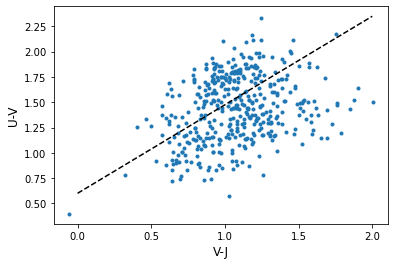

In [7]:
plt.plot(vmin,umin,'.')
plt.plot([0,2],[0.6,2.35],'k--')
plt.xlabel('V-J',fontsize=12)
plt.ylabel('U-V',fontsize=12)
plt.show()

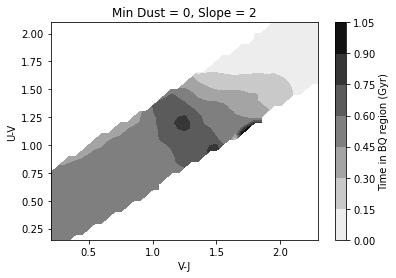

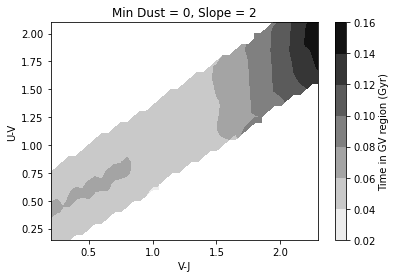

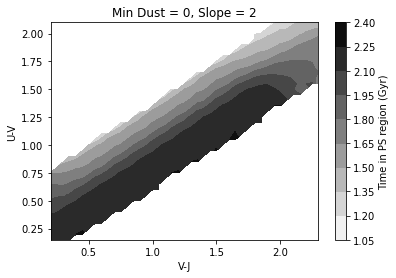

In [27]:
#Process the values from the text files and sort them into the bins on the contour plot
x_v = np.array(range(20,235,5))/100
y_u = np.array(range(15,215,5))/100
z_1=np.zeros([len(y_u),len(x_v)])
z_2=np.zeros([len(y_u),len(x_v)])
z_3=np.zeros([len(y_u),len(x_v)])
z_w=np.zeros([len(y_u),len(x_v)])
w_total = 0
for ii in range(0,len(y_u)):
    for jj in range(0,len(x_v)):
        numb_of = 0
        sum_of = 0
        sum_2 = 0
        sum_3 = 0
        mean_of = 0
        mean_2 = 0
        mean_3 = 0
        weight = 0
        if False:#if y_u[ii] < 0.73*x_v[jj]-0.02 or y_u[ii] > 0.73*x_test[jj]+0.5:
              z_1[ii,jj] = np.nan
        else:
            for kk in range(0,len(trunk_u)):
                if (y_u[ii]-0.1 < trunk_u[kk] and trunk_u[kk] <=y_u[ii]+0.1
                    and x_v[jj]-0.1 < trunk_v[kk] and trunk_v[kk] <=x_v[jj]+0.1):
                    numb_of += 1.0
                    sum_of += times_bq[kk]
                    sum_2 += times_gv[kk]
                    sum_3 += times_out[kk]
            if numb_of > 0:
                mean_of = sum_of/numb_of
                mean_2 = sum_2/numb_of
                mean_3 = sum_3/numb_of
            else:
                mean_of = np.nan
                mean_2 = np.nan
                mean_3 = np.nan
            z_1[ii,jj] = mean_of
            z_2[ii,jj] = mean_2
            z_3[ii,jj] = mean_3
            if numb_of >0:
                for kk in range(0,len(vmin)):
                    if (y_u[ii]-0.1 < umin[kk] and umin[kk] <=y_u[ii]+0.1
                      and x_v[jj]-0.1 < vmin[kk] and vmin[kk] <=x_v[jj]+0.1):
                        weight+=1.0
                        w_total+=1.0
                z_w[ii,jj] = weight
mz_1 = np.ma.masked_invalid(z_1)
mz_2 = np.ma.masked_invalid(z_2)
mz_3 = np.ma.masked_invalid(z_3)
mz_w = z_w/w_total
X_1,Y_1 = np.meshgrid(x_v,y_u)
map1=plt.contourf(X_1,Y_1,mz_1,cmap=cm.gray_r)
cbr=plt.colorbar(map1)
plt.xlabel('V-J')
plt.ylabel('U-V')
plt.title('Min Dust = 0, Slope = {}'.format(nn))
cbr.set_label('Time in BQ region (Gyr)')
plt.show()

map2=plt.contourf(X_1,Y_1,mz_2,cmap=cm.gray_r)
cbr=plt.colorbar(map2)
plt.xlabel('V-J')
plt.ylabel('U-V')
plt.title('Min Dust = 0, Slope = {}'.format(nn))
cbr.set_label('Time in GV region (Gyr)')
plt.show()

map3=plt.contourf(X_1,Y_1,mz_3,cmap=cm.gray_r)
cbr=plt.colorbar(map3)
plt.xlabel('V-J')
plt.ylabel('U-V')
plt.title('Min Dust = 0, Slope = {}'.format(nn))
cbr.set_label('Time in PS region (Gyr)')
plt.show()

In [15]:
means_gv = []
dgv =[]
means_bq = []
dbq = []
means_out =[]
dout =[]

for nn in range(1,7):
    out_data=['','','','','','','','','','','','']
    out_names=['times_out_{}_t3','times_bq_{}_t3','times_gv_{}_t3',
               'trunk_v_{}_t3','trunk_u_{}_t3','trunk_n_{}_t3',
               'dust_a_{}_t3','trunk_a_{}_t3','trunk_d4_{}_t3',
               'trunk_hd_{}_t3','VminJspec','UminVspec']

    for ii in range(0,len(out_data)):
        with open('437_text/{}.txt'.format(out_names[ii].format(nn)),'r') as f:
            out_data[ii]= f.read()
    
    
    times_out = np.array(out_data[0].replace('[','').replace(']','').split(','),dtype=float)
    times_bq = np.array(out_data[1].replace('[','').replace(']','').split(','),dtype=float)
    times_gv = np.array(out_data[2].replace('[','').replace(']','').split(','),dtype=float)
    trunk_v = np.array(out_data[3].replace('[','').replace(']','').split(','),dtype=float)
    trunk_u = np.array(out_data[4].replace('[','').replace(']','').split(','),dtype=float)
    trunk_n = np.array(out_data[5].replace('[','').replace(']','').split(','),dtype=float)
    dust_a = np.array(out_data[6].replace('[','').replace(']','').split(','),dtype=float)
    trunk_a = np.array(out_data[7].replace('[','').replace(']','').split(','),dtype=float)
    trunk_d4 = np.array(out_data[8].replace('[','').replace(']','').split(','),dtype=float)
    trunk_hd = np.array(out_data[9].replace('[','').replace(']','').split(','),dtype=float)

    vmin = out_data[10].replace('[','').replace(']','').split(',')
    umin = out_data[11].replace('[','').replace(']','').split(',')

    vmin = [xx for xx in vmin if xx!= '']
    #vmin = [xx for xx in vmin if xx!= 'nan']
    umin = [xx for xx in umin if xx!= '']
    #umin = [xx for xx in umin if xx!= 'nan']
    #print(vmin)
    #print(umin)

    vmin = np.array(vmin,dtype=float)
    umin = np.array(umin,dtype=float)
    
    x_v = np.array(range(20,235,5))/100
    y_u = np.array(range(15,215,5))/100
    z_1=np.zeros([len(y_u),len(x_v)])
    z_2=np.zeros([len(y_u),len(x_v)])
    z_3=np.zeros([len(y_u),len(x_v)])
    z_w=np.zeros([len(y_u),len(x_v)])
    w_total = 0
    w_nonz = 0
    for ii in range(0,len(y_u)):
        for jj in range(0,len(x_v)):
            numb_of = 0
            sum_g = 0
            sum_bq = 0
            sum_out = 0
            mean_of = 0
            weight = 0
            if False:#if y_u[ii] < 0.73*x_v[jj]-0.02 or y_u[ii] > 0.73*x_test[jj]+0.5:
                  z_1[ii,jj] = np.nan
            else:
                for kk in range(0,len(trunk_u)):
                    if (y_u[ii]-0.1 < trunk_u[kk] and trunk_u[kk] <=y_u[ii]+0.1
                        and x_v[jj]-0.1 < trunk_v[kk] and trunk_v[kk] <=x_v[jj]+0.1):
                        numb_of += 1.0
                        sum_bq += times_bq[kk]
                        sum_g += times_gv[kk]
                        sum_out += times_out[kk]
                if numb_of > 0:
                    mean_bq = sum_bq/numb_of
                    mean_g = sum_g/numb_of
                    mean_out = sum_out/numb_of
                else:
                    mean_bq = np.nan
                    mean_g = np.nan
                    mean_out = np.nan
                z_1[ii,jj] = mean_bq
                z_2[ii,jj] = mean_g
                z_3[ii,jj] = mean_out
                if numb_of >0:
                    for kk in range(0,len(vmin)):
                        if (y_u[ii]-0.1 < umin[kk] and umin[kk] <=y_u[ii]+0.1
                          and x_v[jj]-0.1 < vmin[kk] and vmin[kk] <=x_v[jj]+0.1):
                            weight+=1.0
                            w_total+=1.0
                        z_w[ii,jj] = weight
                        if weight > 0:
                            w_nonz += 1
    mz_b = np.ma.masked_invalid(z_1)
    mz_g = np.ma.masked_invalid(z_2) 
    mz_out = np.ma.masked_invalid(z_3)
    mz_w = z_w/w_total
    
    means_gv.insert(nn-1,np.nansum(mz_g*mz_w))
    dgv.insert(nn-1,np.sqrt(np.nansum(pow(mz_g-means_gv[nn-1],2)*mz_w)))
    means_bq.insert(nn-1,np.nansum(mz_w*mz_b))
    dbq.insert(nn-1,np.sqrt(np.nansum(pow(mz_b-means_bq[nn-1],2)*mz_w)))
    means_out.insert(nn-1,np.nansum(mz_w*mz_out))
    dout.insert(nn-1,np.sqrt(np.nansum(pow(mz_out-means_out[nn-1],2)*mz_w)))

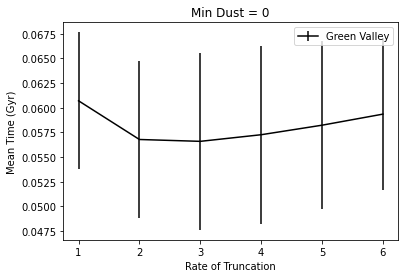

In [16]:
#Plot the weighted averages. Just uncomment the desired one

plt.errorbar(range(1,7),means_gv,yerr=dgv,color='k',label='Green Valley') #BQ
#plt.errorbar(range(1,7),means_bq,yerr=dbq,color='k',label='Blue Quiescent') #GV
#plt.errorbar(range(1,7),means_out,yerr=dout,color='k',label="Post Starburst") #PS
plt.xlabel('Rate of Truncation')
plt.ylabel('Mean Time (Gyr)')
plt.title('Min Dust = 0')
plt.legend()

# Interpret dust for 0.4 minimum

The following sections interpret data with the caviat that the minimum dust is 0.4 instead of 0

In [32]:
nn = 2
out_data=['','','','','','','','','','','','']
out_names=['times_out_{}_dp4','times_bq_{}_dp4','times_gv_{}_dp4',
           'trunk_v_{}_dp4','trunk_u_{}_dp4','trunk_n_{}_dp4',
           'dust_a_{}_dp4','trunk_a_{}_dp4','trunk_d4_{}_dp4',
           'trunk_hd_{}_dp4','VminJspec','UminVspec']

for ii in range(0,len(out_data)):
    with open('437_text/{}.txt'.format(out_names[ii].format(nn)),'r') as f:
        out_data[ii]= f.read()

In [33]:
times_out = np.array(out_data[0].replace('[','').replace(']','').split(','),dtype=float)
times_bq = np.array(out_data[1].replace('[','').replace(']','').split(','),dtype=float)
times_gv = np.array(out_data[2].replace('[','').replace(']','').split(','),dtype=float)
trunk_v = np.array(out_data[3].replace('[','').replace(']','').split(','),dtype=float)
trunk_u = np.array(out_data[4].replace('[','').replace(']','').split(','),dtype=float)
trunk_n = np.array(out_data[5].replace('[','').replace(']','').split(','),dtype=float)
dust_a = np.array(out_data[6].replace('[','').replace(']','').split(','),dtype=float)
trunk_a = np.array(out_data[7].replace('[','').replace(']','').split(','),dtype=float)
trunk_d4 = np.array(out_data[8].replace('[','').replace(']','').split(','),dtype=float)
trunk_hd = np.array(out_data[9].replace('[','').replace(']','').split(','),dtype=float)

vmin = out_data[10].replace('[','').replace(']','').split(',')
umin = out_data[11].replace('[','').replace(']','').split(',')

vmin = [xx for xx in vmin if xx!= '']
#vmin = [xx for xx in vmin if xx!= 'nan']
umin = [xx for xx in umin if xx!= '']
#umin = [xx for xx in umin if xx!= 'nan']
#print(vmin)
#print(umin)

vmin = np.array(vmin,dtype=float)
umin = np.array(umin,dtype=float)

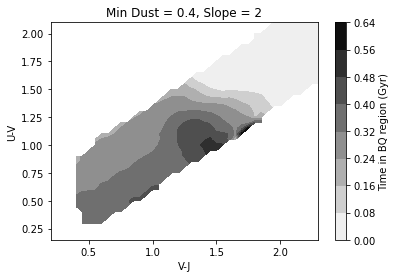

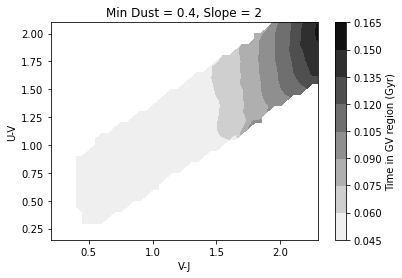

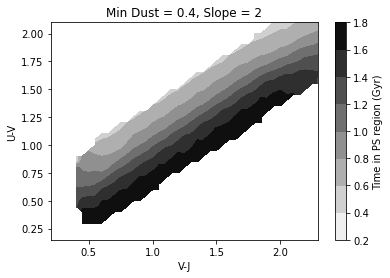

In [34]:
x_v = np.array(range(20,235,5))/100
y_u = np.array(range(15,215,5))/100
z_1=np.zeros([len(y_u),len(x_v)])
z_2=np.zeros([len(y_u),len(x_v)])
z_3=np.zeros([len(y_u),len(x_v)])
z_w=np.zeros([len(y_u),len(x_v)])
w_total = 0
for ii in range(0,len(y_u)):
    for jj in range(0,len(x_v)):
        numb_of = 0
        sum_of = 0
        sum_2 = 0
        sum_3 = 0
        mean_of = 0
        mean_2 = 0
        mean_3 = 0
        weight = 0
        if False:#if y_u[ii] < 0.73*x_v[jj]-0.02 or y_u[ii] > 0.73*x_test[jj]+0.5:
              z_1[ii,jj] = np.nan
        else:
            for kk in range(0,len(trunk_u)):
                if (y_u[ii]-0.1 < trunk_u[kk] and trunk_u[kk] <=y_u[ii]+0.1
                    and x_v[jj]-0.1 < trunk_v[kk] and trunk_v[kk] <=x_v[jj]+0.1):
                    numb_of += 1.0
                    sum_of += times_bq[kk]
                    sum_2 += times_gv[kk]
                    sum_3 += times_out[kk]
            if numb_of > 0:
                mean_of = sum_of/numb_of
                mean_2 = sum_2/numb_of
                mean_3 = sum_3/numb_of
            else:
                mean_of = np.nan
                mean_2 = np.nan
                mean_3 = np.nan
            z_1[ii,jj] = mean_of
            z_2[ii,jj] = mean_2
            z_3[ii,jj] = mean_3
            if numb_of >0:
                for kk in range(0,len(vmin)):
                    if (y_u[ii]-0.1 < umin[kk] and umin[kk] <=y_u[ii]+0.1
                      and x_v[jj]-0.1 < vmin[kk] and vmin[kk] <=x_v[jj]+0.1):
                        weight+=1.0
                        w_total+=1.0
                z_w[ii,jj] = weight
mz_1 = np.ma.masked_invalid(z_1)
mz_2 = np.ma.masked_invalid(z_2)
mz_3 = np.ma.masked_invalid(z_3)
mz_w = z_w/w_total
X_1,Y_1 = np.meshgrid(x_v,y_u)
map1=plt.contourf(X_1,Y_1,mz_1,cmap=cm.gray_r)
cbr=plt.colorbar(map1)
plt.xlabel('V-J')
plt.ylabel('U-V')
plt.title('Min Dust = 0.4, Slope = {}'.format(nn))
cbr.set_label('Time in BQ region (Gyr)')
plt.show()

map2=plt.contourf(X_1,Y_1,mz_2,cmap=cm.gray_r)
cbr=plt.colorbar(map2)
plt.xlabel('V-J')
plt.ylabel('U-V')
plt.title('Min Dust = 0.4, Slope = {}'.format(nn))
cbr.set_label('Time in GV region (Gyr)')
plt.show()

map3=plt.contourf(X_1,Y_1,mz_3,cmap=cm.gray_r)
cbr=plt.colorbar(map3)
plt.xlabel('V-J')
plt.ylabel('U-V')
plt.title('Min Dust = 0.4, Slope = {}'.format(nn))
cbr.set_label('Time in PS region (Gyr)')
plt.show()

In [31]:
means_gv = []
dgv =[]
means_bq = []
dbq = []
means_out =[]
dout =[]

for nn in range(1,7):
    out_data=['','','','','','','','','','','','']
    out_names=['times_out_{}_dp4','times_bq_{}_dp4','times_gv_{}_dp4',
               'trunk_v_{}_dp4','trunk_u_{}_dp4','trunk_n_{}_dp4',
               'dust_a_{}_dp4','trunk_a_{}_dp4','trunk_d4_{}_dp4',
               'trunk_hd_{}_dp4','VminJspec','UminVspec']

    for ii in range(0,len(out_data)):
        with open('437_text/{}.txt'.format(out_names[ii].format(nn)),'r') as f:
            out_data[ii]= f.read()
    
    
    times_out = np.array(out_data[0].replace('[','').replace(']','').split(','),dtype=float)
    times_bq = np.array(out_data[1].replace('[','').replace(']','').split(','),dtype=float)
    times_gv = np.array(out_data[2].replace('[','').replace(']','').split(','),dtype=float)
    trunk_v = np.array(out_data[3].replace('[','').replace(']','').split(','),dtype=float)
    trunk_u = np.array(out_data[4].replace('[','').replace(']','').split(','),dtype=float)
    trunk_n = np.array(out_data[5].replace('[','').replace(']','').split(','),dtype=float)
    dust_a = np.array(out_data[6].replace('[','').replace(']','').split(','),dtype=float)
    trunk_a = np.array(out_data[7].replace('[','').replace(']','').split(','),dtype=float)
    trunk_d4 = np.array(out_data[8].replace('[','').replace(']','').split(','),dtype=float)
    trunk_hd = np.array(out_data[9].replace('[','').replace(']','').split(','),dtype=float)

    vmin = out_data[10].replace('[','').replace(']','').split(',')
    umin = out_data[11].replace('[','').replace(']','').split(',')

    vmin = [xx for xx in vmin if xx!= '']
    #vmin = [xx for xx in vmin if xx!= 'nan']
    umin = [xx for xx in umin if xx!= '']
    #umin = [xx for xx in umin if xx!= 'nan']
    #print(vmin)
    #print(umin)

    vmin = np.array(vmin,dtype=float)
    umin = np.array(umin,dtype=float)
    
    x_v = np.array(range(20,235,5))/100
    y_u = np.array(range(15,215,5))/100
    z_1=np.zeros([len(y_u),len(x_v)])
    z_2=np.zeros([len(y_u),len(x_v)])
    z_3=np.zeros([len(y_u),len(x_v)])
    z_w=np.zeros([len(y_u),len(x_v)])
    w_total = 0
    for ii in range(0,len(y_u)):
        for jj in range(0,len(x_v)):
            numb_of = 0
            sum_g = 0
            sum_bq = 0
            sum_out = 0
            mean_of = 0
            weight = 0
            if False:#if y_u[ii] < 0.73*x_v[jj]-0.02 or y_u[ii] > 0.73*x_test[jj]+0.5:
                  z_1[ii,jj] = np.nan
            else:
                for kk in range(0,len(trunk_u)):
                    if (y_u[ii]-0.1 < trunk_u[kk] and trunk_u[kk] <=y_u[ii]+0.1
                        and x_v[jj]-0.1 < trunk_v[kk] and trunk_v[kk] <=x_v[jj]+0.1):
                        numb_of += 1.0
                        sum_bq += times_bq[kk]
                        sum_g += times_gv[kk]
                        sum_out += times_out[kk]
                if numb_of > 0:
                    mean_bq = sum_bq/numb_of
                    mean_g = sum_g/numb_of
                    mean_out = sum_out/numb_of
                else:
                    mean_bq = np.nan
                    mean_g = np.nan
                    mean_out = np.nan
                z_1[ii,jj] = mean_bq
                z_2[ii,jj] = mean_g
                z_3[ii,jj] = mean_out
                if numb_of >0:
                    for kk in range(0,len(vmin)):
                        if (y_u[ii]-0.1 < umin[kk] and umin[kk] <=y_u[ii]+0.1
                          and x_v[jj]-0.1 < vmin[kk] and vmin[kk] <=x_v[jj]+0.1):
                            weight+=1.0
                            w_total+=1.0
                        z_w[ii,jj] = weight
    mz_b = np.ma.masked_invalid(z_1)
    mz_g = np.ma.masked_invalid(z_2) 
    mz_out = np.ma.masked_invalid(z_3)
    mz_w = z_w/w_total
    
    means_gv.insert(nn-1,np.nansum(mz_g*mz_w))
    dgv.insert(nn-1,np.sqrt(np.nansum(pow(mz_g-means_gv[nn-1],2)*mz_w)))
    means_bq.insert(nn-1,np.nansum(mz_w*mz_b))
    dbq.insert(nn-1,np.sqrt(np.nansum(pow(mz_b-means_bq[nn-1],2)*mz_w)))
    means_out.insert(nn-1,np.nansum(mz_w*mz_out))
    dout.insert(nn-1,np.sqrt(np.nansum(pow(mz_out-means_out[nn-1],2)*mz_w)))

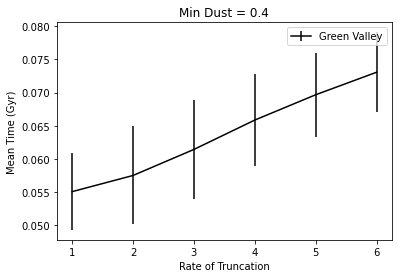

In [20]:
plt.errorbar(range(1,7),means_gv,yerr=dgv,color='k',label='Green Valley')
#plt.errorbar(range(1,7),means_bq,yerr=dbq,color='k',label='Blue Quiescent')
#plt.errorbar(range(1,7),means_out,yerr=dout,color='k',label="Post Starburst")
plt.xlabel('Rate of Truncation')
plt.ylabel('Mean Time (Gyr)')
plt.title('Min Dust = 0.4')
plt.legend()

# Subset of Paths

In [4]:
reg = [4030,4082,4082,4122,4122,4170]

start = 1.0
trunk = 7.0
zred = 0.0
tau = 100.0
metal = 0.0
dust = 2.0
sfh = 5

dust1 = dust
bands_in = [ 'galex_nuv', 'sdss_u', 'fors_v', 'vista_j' ]

nuv_v=[]
v_j=[]
u_v=[]
nuv_v1=[]
v_j1=[]
u_v1=[]
blue = []
red = []
ha = []

cols = ['k','r','g','c','orange','purple']

In [5]:
sp = fsps.StellarPopulation(compute_vega_mags=False, zcontinuous=1, tau = tau,
							sfh=sfh, logzsol=metal, dust_type=2, dust2=dust,sf_trunc=trunk,sf_slope=-1)

In [6]:
#to make thinkgs easier
start = 0.1
trunk = 1000
zred = 0.0
tau = 0.1
metal = 0.0

sp.params['add_neb_emission']=0

dust = 0.5
sfh = 1

sp.params['sfh']=sfh
sp.params['tau'] = tau

dust1 = dust
bands_in = [ 'galex_nuv', 'sdss_u', 'fors_v', 'vista_j' ]

Started
0:01:17.211793
0:01:26.563630
0:01:36.043311
0:01:45.558564
0:01:54.994349
0:02:04.506521
[2.1, 1.97, 1.82, 1.57, 1.37, 1.3]
[0.36, 0.41, 0.34, 0.275, 0.27, 0.125]


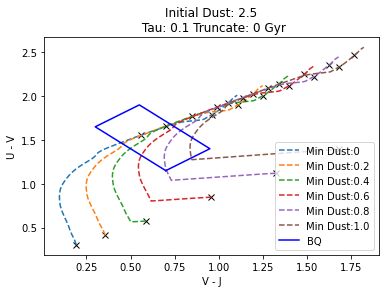

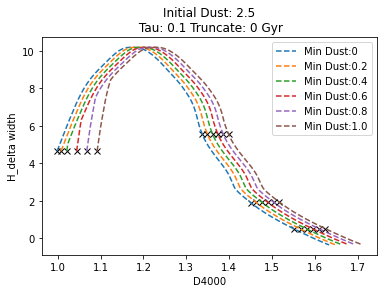

In [7]:
f1 = plt.figure()
f2 = plt.figure()
ax1 = f1.add_subplot(111)
ax2 = f2.add_subplot(111)

start_time = dt.now()
print("Started")
times_out = []
times_bq = []
rat = []
toto = []
tau=0.1
mindust=0

for jj in range(0,6):
    sp.params['tau'] =tau
    #=============Change these values to determine constant/changing values
    #slope= jj*jj*.2
    slope = 5
    dust1 = 0.5*jj
    dust = dust1
    trunk = 0
    #trunk = jj*jj*.2+2
    sp.params['sf_slope'] = -slope
    sp.params['sf_trunc'] = trunk
    nuv_v=[]
    v_j=[]
    u_v=[]
    nuv_v1=[]
    v_j1=[]
    u_v1=[]
    blue = []
    red = []
    ha = []
    
    time_out = 0
    time_bq = 0
    for ii in range(0,int(800)): 
        time = start+ii*0.005
        if jj == 3:
            toto.insert(ii,time)
        if time > trunk:# and trunk!= 0:
            dust = max(mindust, dust1-slope*(time-trunk))
        #if time > trunk:
        #    dust = max(mindust,dust1*np.exp(-((time)/tau)))
        sp.params['dust2'] = dust
      
        wave,spec = sp.get_spectrum(tage=time)
        ha.insert(ii,line_index(wave,spec,reg))
        #ha.insert(ii,lin_wid(wave,spec,4100,50))
        wave_start = np.argmin(abs(3850-wave))
        wave_end = np.argmin(abs(3950-wave))
        spec_sec = sum(spec[wave_start:wave_end]/(wave[wave_start:wave_end]*wave[wave_start:wave_end]))
        blue.insert(ii,spec_sec)
        wave_start = np.argmin(abs(4000-wave))
        wave_end = np.argmin(abs(4100-wave))
        spec_sec = sum(spec[wave_start:wave_end]/(wave[wave_start:wave_end]*wave[wave_start:wave_end]))
        red.insert(ii,spec_sec)
        
        if jj == 3:
            rat.insert(ii,sp.sfr)
        
        if red[ii]/blue[ii]  < 1.45 and time > trunk:
            time_out = round(time - trunk,2)
        
        mags = sp.get_mags(tage=time,bands = bands_in)
        nuv_v1.insert(ii, mags[0] - mags[2])
        v_j1.insert(ii,mags[2] - mags[3] )
        u_v1.insert(ii,mags[1] - mags [2] )
        
        b_1 = v_j1[ii] + 0.45
        b_2 = -1.25*v_j1[ii] + 2.025
        t_1 = -1.25*v_j1[ii] + 2.5875
        t_2 = v_j1[ii] + 1.35
        #if ii%50 ==0:
        #    ax1.plot(v_j1[ii],b_1,'b|')
        #    ax1.plot(v_j1[ii],b_2,'b|')
        #    ax1.plot(v_j1[ii],t_1,'b|')
        #    ax1.plot(v_j1[ii],t_2,'b|')
        
        
        if mags[1] - mags[2] > b_1 and mags[1] - mags[2] > b_2 and mags[1] - mags[2] < t_1 and mags[1] - mags[2] < t_2:
            time_bq += round(0.005,3)
      
        if ii%200 == 0:
            ax1.plot(mags[2] - mags[3] ,mags[1] - mags[2] ,'kx')
            ax2.plot(red[ii]/blue[ii],ha[ii],'kx')
    ax1.plot(v_j1,u_v1,linestyle='--',label='Min Dust:{}'.format(round(mindust,2)))
    red = np.array(red)
    blue=np.array(blue)
    R4 = red/blue
    ax2.plot(R4,ha,linestyle='--',label='Min Dust:{}'.format(round(mindust,2)))
    times_out.insert(jj,time_out)
    times_bq.insert(jj,round(time_bq,3))
    print(dt.now()-start_time)
    mindust+=0.2
    
    
print(times_out)
print(times_bq)
ax1.plot([0.7,0.95,0.55,0.3,0.7],[1.15,1.4,1.9,1.65,1.15],'b',label='BQ')
ax1.set_xlabel('V - J')
ax1.set_ylabel('U - V')
ax2.set_xlabel('D4000')
ax2.set_ylabel(u'H_delta width')

ax1.legend()
ax1.set_title('Initial Dust: {}\n Tau: 0.1 Truncate: {} Gyr'.format(dust1,trunk))
ax2.set_title('Initial Dust: {}\n Tau: 0.1 Truncate: {} Gyr'.format(dust1,trunk))
ax2.legend()
plt.show()